In [1]:
import pprint
import re
import pickle
import unicodedata
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#DB connection
MONGODB_HOST = 'localhost'
MONGODB_PORT = 27017
DBS_NAME = 'KSCHOOL_TFM'
COLLECTION_NAME = 'tweets'
connection = MongoClient(MONGODB_HOST, MONGODB_PORT) #getting client
db_tweets = connection[DBS_NAME][COLLECTION_NAME] #getting db    


**Important note:** The data used in the notebook comes from a live database. The database stores tweets continously. Thus, metrics from the databese will be different in different parts of the notebooks. However, we mostly calculate relative metrix from a large sample thus results should be representative.

- coordinates: Represents the geographic location of this Tweet as reported by the user or client application. The inner coordinates array is formatted as geoJSON (longitude first, then latitude)

- geo: *Deprecated* Use the “coordinates” field instead.

- place: When present, indicates that the tweet is associated (but not necessarily originating from) a Place. 

- user.location: The user-defined location for this account’s profile. Not necessarily a location nor parseable. This field will occasionally be fuzzily interpreted by the Search service.


## tweets with coordinates

In [33]:
n_tweets_with_coordinates = db_tweets.find({"coordiantes": {'$ne': None}}).count()
print("There are {} tweets with coordinates".format(n_tweets_with_coordinates))

There are 0 tweets with coordinates


## tweets with place

In [25]:
n_tweets_with_places = db_tweets.find({"place": {'$ne': None}}).count()
n_tweets = db_tweets.find().count()

In [31]:
print("{} out of {} tweets have 'place' field, that is {:.2f}% of tweets".format(n_tweets_with_places, n_tweets, 100*n_tweets_with_places/float(n_tweets)  ))

30293 out of 1148446 tweets have 'place' field, that is 2.64% of tweets


Example content of place in tweet

In [34]:
t=db_tweets.find_one({"place": {'$ne': None}})
pprint.pprint(t['place'])

{u'attributes': {},
 u'bounding_box': {u'coordinates': [[[-74.685619, 39.236269],
                                     [-74.661043, 39.236269],
                                     [-74.661043, 39.2512758],
                                     [-74.685619, 39.2512758]]],
                   u'type': u'Polygon'},
 u'contained_within': [],
 u'country': u'United States',
 u'country_code': u'US',
 u'full_name': u'Palermo, NJ',
 u'id': u'00bc1ea14f9a46c7',
 u'name': u'Palermo',
 u'place_type': u'city',
 u'url': u'https://api.twitter.com/1.1/geo/id/00bc1ea14f9a46c7.json'}


## user location

In [40]:
n_tweets_with_location = db_tweets.find({"user.location": {'$ne': u''}}).count()
n_tweets = db_tweets.find().count()

In [41]:
print("{} out of {} tweets have 'user.location' field, that is {:.2f}% of tweets".format(n_tweets_with_location, n_tweets, 100*n_tweets_with_location/float(n_tweets)  ))

799609 out of 1150441 tweets have 'user.location' field, that is 69.50% of tweets


Example user locations:

In [56]:
tweets = db_tweets.find({"user.location": {'$ne': u''}}).limit(20)
locations = [tweet['user']['location'] for tweet in tweets]
print('\n'.join(locations))

South Jersey
San Diego, CA
Austin, TX
Alma, Kansas
Maryland, USA
Unicorn Island
Portland, OR
Northside478
grind
Arkham
Orlando, FL
Duluth, GA
Bessemer AL
Atlanta
Atlanta, GA
Madison, CT
NYC
NYC
Spartanburg, SC
Walt Disney World


As can be seen, the location field is not structured and may contain fictional information

# User location field format

Lets extract unique tweet locations

In [23]:
locations_tweets = db_tweets.find({"user.location":{"$ne":''}}).distinct('user.location')
n_tweets = db_tweets.find().count()
n_nonempty_locations_tweets = db_tweets.find({"user.location":{"$ne":''}}).count()
n_unique_locations = len(locations_tweets)

In [24]:
print("There are {} unique locations in {} stored tweets ({:.2f} repetition rate). Also, there are {} users with non empty location field, thus, with respect to nonempty locations, there is a {:.2f} repetion rate".format(n_unique_locations, n_tweets, float(n_unique_locations)/n_tweets, n_nonempty_locations_tweets, float(n_unique_locations)/n_nonempty_locations_tweets))

There are 263020 unique locations in 1536626 stored tweets (0.17 repetition rate). Also, there are 1070231 users with non empty location field, thus, with respect to nonempty locations, there is a 0.25 repetion rate


In [13]:
#pickle.dump(locations_tweets, open('/home/michael/locations.p','w'))
locations_tweets = pickle.load(open('/home/michael/locations.p'))

#to convert to unicode
#unicodedata.normalize('NFD', unicode('asbs')).encode('ASCII', 'ignore')
#split_nonalphabetic_or_space = lambda x: map(lambda y: y.strip(), re.split('[^A-Z^a-z\s]',x))
locations_tweets_split1 = map(split_nonalphabetic_or_space, locations_tweets)
fields_length = np.array(map(lambda x: len(x), locations_tweets_split1))
#H, X1 = np.histogram(fields_length, max(fields_length-1), normed=True)
                     

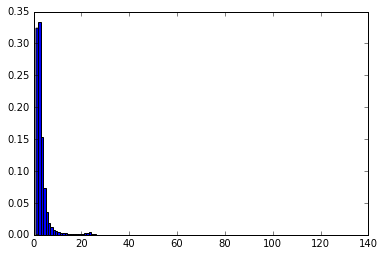

In [15]:
fig, ax = plt.subplots()
ax.hist(fields_length,max(fields_length-1), normed=1)
plt.show()

# Using geonames database to geotag location

In [62]:
# Load csv with tailored geonames info
geonameid_info_dict = pickle.load(open('../geonames/geonameid_info_dict.p'))
name_geonameidLIST_dict = pickle.load(open('../geonames/name_geonameidLIST_dict.p'))
asciiname_geonameidLIST_dict = pickle.load(open('../geonames/asciiname_geonameidLIST_dict.p'))
altnames_geonameidLIST_dict = pickle.load(open('../geonames/altnames_geonameidLIST_dict.p'))

In [181]:
def geotag_location(location):
    location = location.lower()
    ll=[ location.strip().split(',')[0],
         location.strip().split(' ')[0],
         location.strip().split(' ')[-1],        
         location.strip().split(',')[-1],      
         location.strip().split('/')[0],     
         location.strip().split('/')[-1],        
         location.strip().split('.')[0],        
         location.strip().split('.')[-1],        
         location.strip().split('-')[0],        
         location.strip().split('-')[-1] ]        
    geoids = None
    for l in ll: 
        if l in name_geonameidLIST_dict:
            geoids = name_geonameidLIST_dict[l]
            break
        if l in altnames_geonameidLIST_dict: 
            geoids = altnames_geonameidLIST_dict[l]
            break
        if unicodedata.normalize('NFD', unicode(l)).encode('ASCII', 'ignore') in asciiname_geonameidLIST_dict: 
            geoids = asciiname_geonameidLIST_dict[unicodedata.normalize('NFD', unicode(l)).encode('ASCII', 'ignore')]
            break
    if geoids is None: return None, None
    
    # use geoid from largest population
    geoid = geoids[max(enumerate(map(lambda geoid: geonameid_info_dict[geoid]['population'], geoids)), key=lambda x: x[1])[0]]

    info = geonameid_info_dict [ geoid ]
    return info, geoid

In [128]:
name = "Los Madriles"
info, geoid = geotag_location(name)
print("'{}' official name is '{}' and has coordinates = ({}, {})".format(name, info['name'], info['latitude'], info['longitude']))

'Los Madriles' official name is 'Madrid' and has coordinates = (40.4165, -3.70256)
